## Transformer based NER
- XLM-RoBERTa
- Zero-shot transfer/ zero-short learning
    - use model trained on one dataset used for predicting antoher set of data

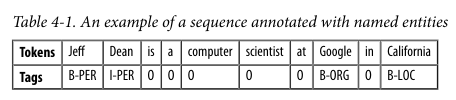



In [1]:
from datasets import get_dataset_config_names

xtreme_subsets = get_dataset_config_names("xtreme")
print(f"XTREME has {len(xtreme_subsets)} configurations")

# now look for configuration starts with 'PAN'
panx_subsets = [s for s in xtreme_subsets if s.startswith("PAN")]
panx_subsets[:3]

XTREME has 183 configurations


['PAN-X.af', 'PAN-X.ar', 'PAN-X.bg']